<a id='main' name="main"></a>
# Vital Data Analysis

Date: 2024.10.14
Author: © 2024 Ignas Biekša

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

In this work we answer the questions:
1. How do the age of a vehicle, transmission, and its mileage correlate with the vehicle's selling price?
2. What is the prediction of the selling price of a vehicle based on its various features?
3. What is the classification of the vehicles condition based on its age, mileage, and other features?"

Using the open data from: 
* [Kaggle](https://www.kaggle.com/) - [Vehicle Sales Data](https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data)


This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a>  

**Prerequisites** \
First we load the data from `./laptop.csv` into a `pandas` dataframe, having imported ```pandas as pd```

In [226]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

cars_df = pd.read_csv('./car_prices.csv')

cars_df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


Subsequently, we perform some simple data cleanup by dropping duplicate rows and rows with empty or invalid values. Additionally data is augmented by creating derived properties such as `salemonth`, `vehicleage`, and `conditionlabel`

In [227]:
cars_df.drop_duplicates(inplace=True)
cars_df['saledate'] = cars_df['saledate'].apply(lambda date_str: re.sub(r'\s*\(.*?\)', '', str(date_str)))
cars_df['saledate'] = pd.to_datetime(cars_df['saledate'], errors='coerce', utc=True, format='%a %b %d %Y %H:%M:%S GMT%z')
cars_df.dropna(inplace=True)

cars_df['salemonth'] = cars_df['saledate'].dt.month.astype(int)
cars_df['vehicleage'] = cars_df['saledate'].dt.year - cars_df['year']
cars_df = cars_df[cars_df['vehicleage'] >= 0]
cars_df['conditionlabel'] = pd.qcut(cars_df['condition'], 4, labels=["bad", "average", "good", "very good"])

We perfom simple data analysis to understand the data better. We can see that the average selling price of a car is *$13685*, *$147* less than the recommended sale price (mmr), the average mileage is *66719 miles*, and the average age of a car is *4.7 years*.\
Upon closer inspection, we can also tell there are some outlying values by seeing how different the max and min values are by comparison to the quartile values. These outliers will be removed in further steps to fascilitate better predictions and classifications.\
We can also see there are some records with matching vin numbers. Apparently, this happens in real life so we'll give it the benefit of the doubt as other duplicates had been removed in previous steps.

In [228]:
continuous_features = cars_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = cars_df.select_dtypes(include=['object', 'category']).columns.tolist()

cars_continuous_df = cars_df[continuous_features]
cars_categorical_df = cars_df[categorical_features]

print("Number of rows:", len(cars_df))
print("Number of features:", len(continuous_features) + len(categorical_features))
print("Continuous features:", continuous_features)
print("Categorical features:", categorical_features)
categorical_summary = cars_categorical_df.describe().T
continuous_summary = cars_continuous_df.describe().T

continuous_summary['% missing rows'] = cars_continuous_df.isnull().mean() * 100
continuous_summary['unique'] = cars_continuous_df.nunique()
categorical_summary['% missing rows'] = cars_categorical_df.isnull().mean() * 100
categorical_summary['Mode'] = cars_categorical_df.mode().iloc[0] 
categorical_summary['Mode Freq'] = cars_categorical_df.apply(lambda x: x.value_counts().iloc[0])
categorical_summary['Mode %'] = categorical_summary['Mode Freq'] / len(cars_categorical_df) * 100
categorical_summary['2nd Mode'] = cars_categorical_df.apply(lambda x: x.value_counts().index[1] if len(x.value_counts()) > 1 else 0)
categorical_summary['2nd Mode Freq'] = cars_categorical_df.apply(lambda x: x.value_counts().iloc[1] if len(x.value_counts()) > 1 else 0)
categorical_summary['2nd Mode %'] = categorical_summary['2nd Mode Freq'] / len(cars_categorical_df) * 100

print("Continuous features summary:\n", continuous_summary)
print("Continuous features summary:\n", categorical_summary)

Number of rows: 472168
Number of features: 18
Continuous features: ['year', 'condition', 'odometer', 'mmr', 'sellingprice', 'salemonth', 'vehicleage']
Categorical features: ['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'color', 'interior', 'seller', 'conditionlabel']
Continuous features summary:
                  count          mean           std     min      25%      50%  \
year          472168.0   2010.209387      3.821788  1990.0   2008.0   2012.0   
condition     472168.0     30.774299     13.284507     1.0     24.0     35.0   
odometer      472168.0  66719.894112  51938.511040     1.0  28156.0  51105.0   
mmr           472168.0  13832.347385   9527.643931    25.0   7425.0  12300.0   
sellingprice  472168.0  13685.932037   9608.400330     1.0   7200.0  12200.0   
salemonth     472168.0      3.618562      3.039319     1.0      1.0      2.0   
vehicleage    472168.0      4.713034      3.818820     0.0      2.0      3.0   

                  75%       max  % missin

In this next step histograms of continuous features get plotted to visualise the amount of outliers for each property that could later affect the accuracy of regression and classification models. Later, these outliers are removed using the interquartile range method.

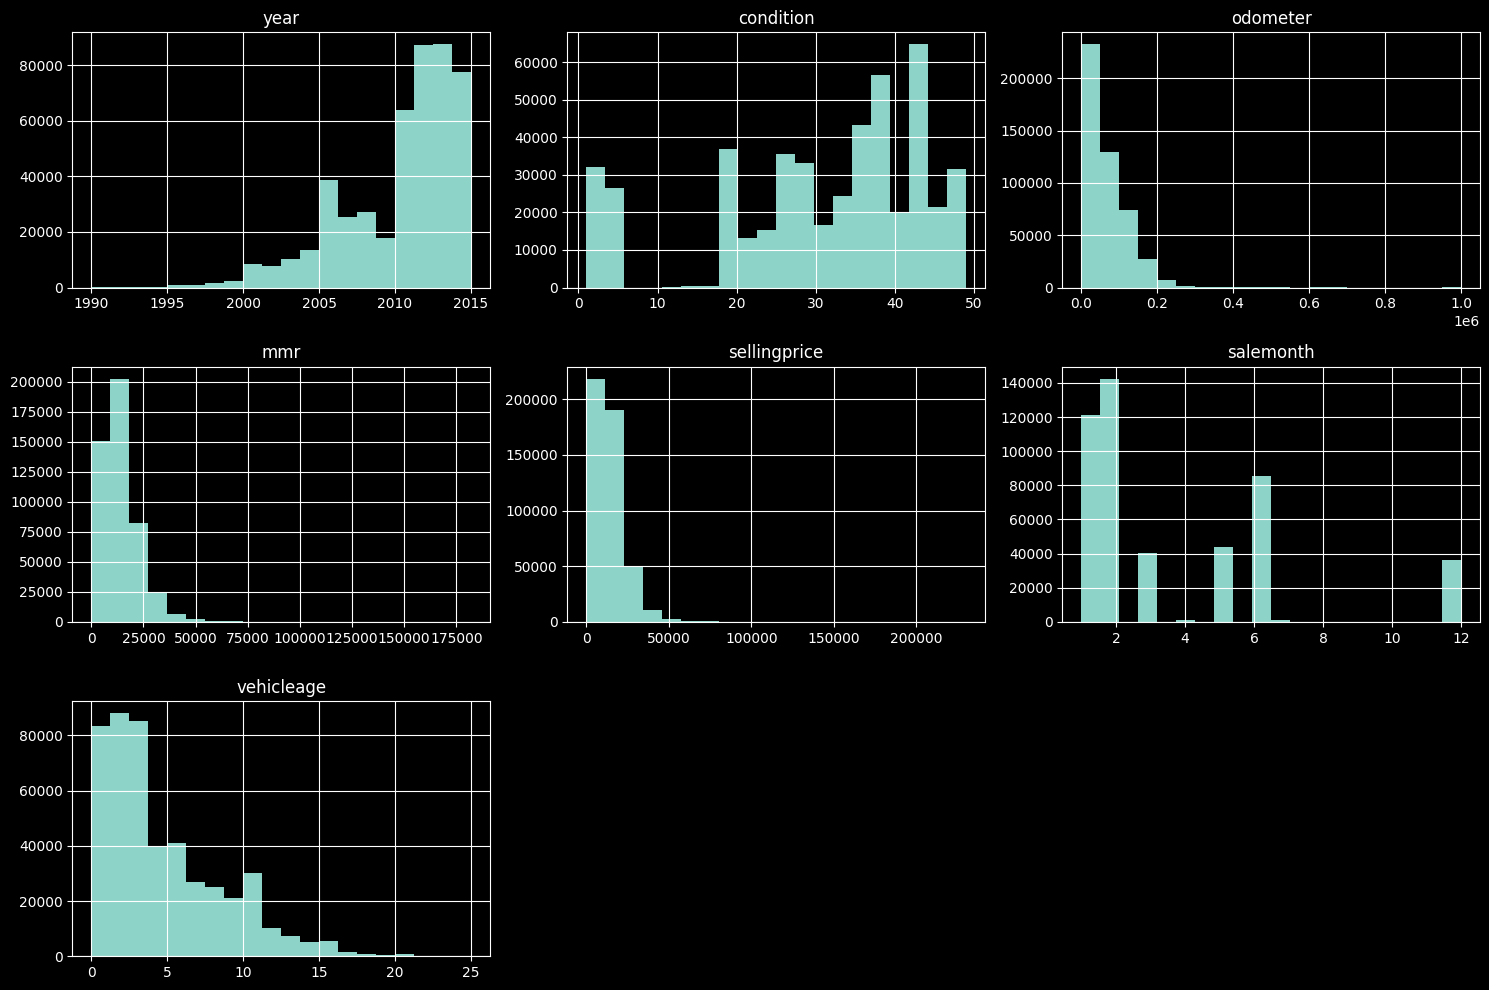

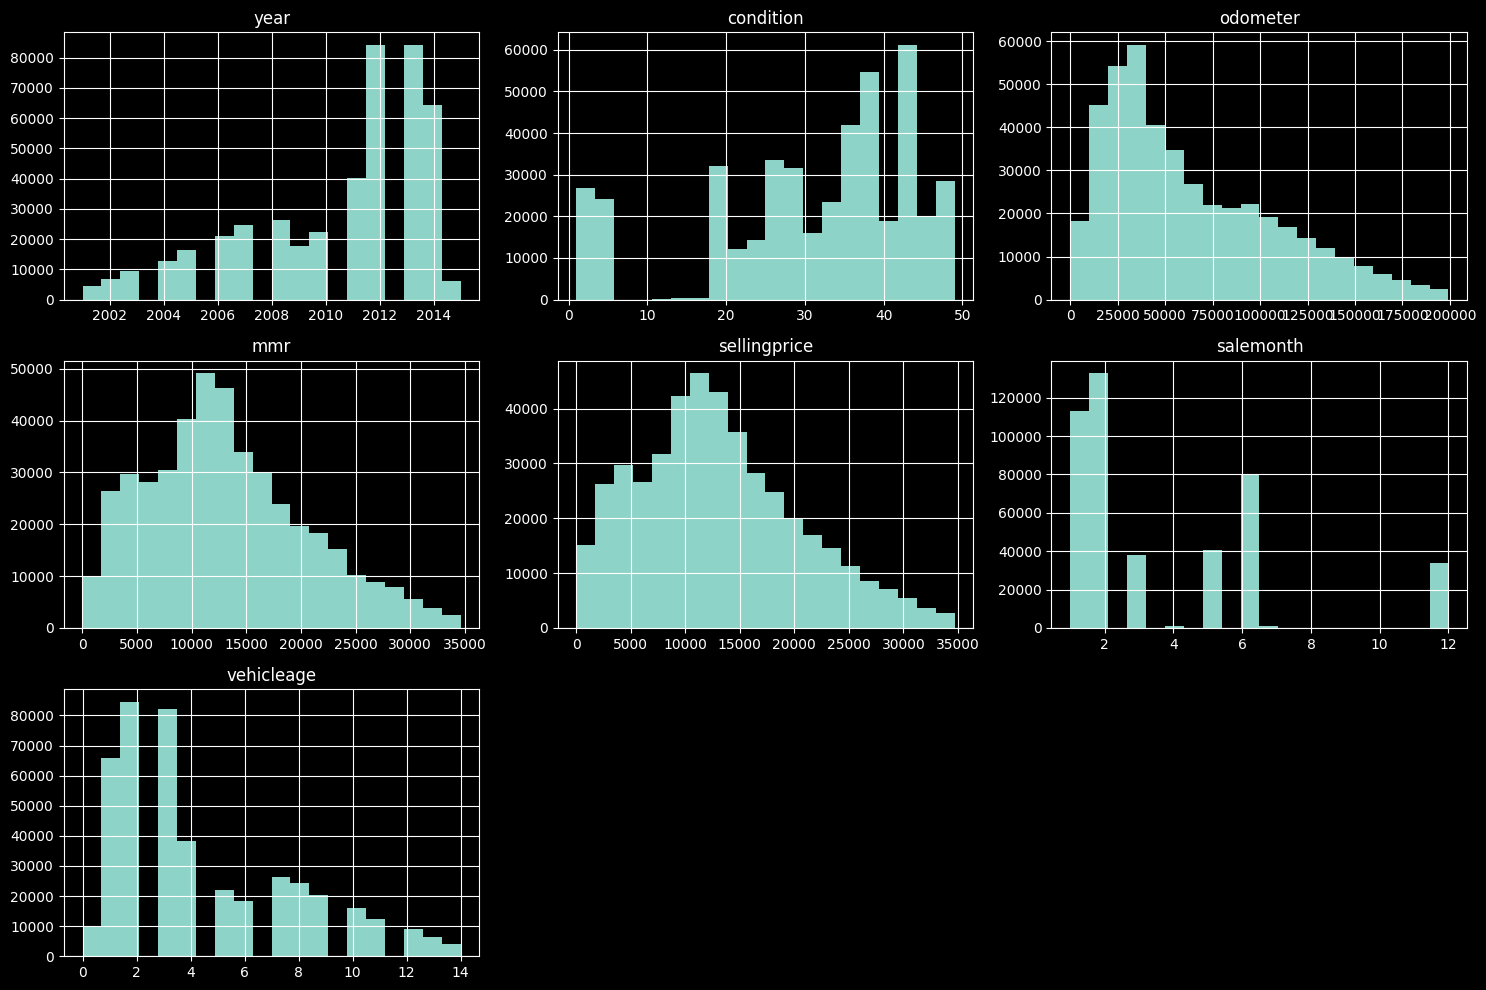

In [229]:
from sklearn.preprocessing import StandardScaler
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

def plot(df):
    df.hist(bins=20, figsize=(15, 10))
    plt.tight_layout()
    plt.show()


plot(cars_continuous_df)
cars_no_outliers_df = remove_outliers(cars_continuous_df)
plot(cars_no_outliers_df)

### 1. How do the age of a vehicle, transmission, and its mileage correlate with the vehicle's selling price?
We calculate the correlation between the `mileage` `vehicleage` and `sellingprice` using Pearson's method and have the results displayed in a correlation matrix. We can see that both the mileage and age are inversely proportional to the selling price to an almost identical extent (both correlation coeficients are *-0.577*). Whereas the age and mileage are closely directly proportional by a coefficient of *0.772*. The effect on selling price by mileage and age, along with transmission type are visualized below the correlation matrix. We can see that as the car ages the mileage grows and the price drops. We can also see that on average automatic transmission cars sell for more. The mean of manual cars is closer to the first quartile of automatics than it is to the mean.

Correlation matrix:
               odometer  vehicleage  sellingprice
odometer      1.000000    0.771647     -0.577385
vehicleage    0.771647    1.000000     -0.577123
sellingprice -0.577385   -0.577123      1.000000
Correlation between selling price and transmission type:
 -0.04606508092082431


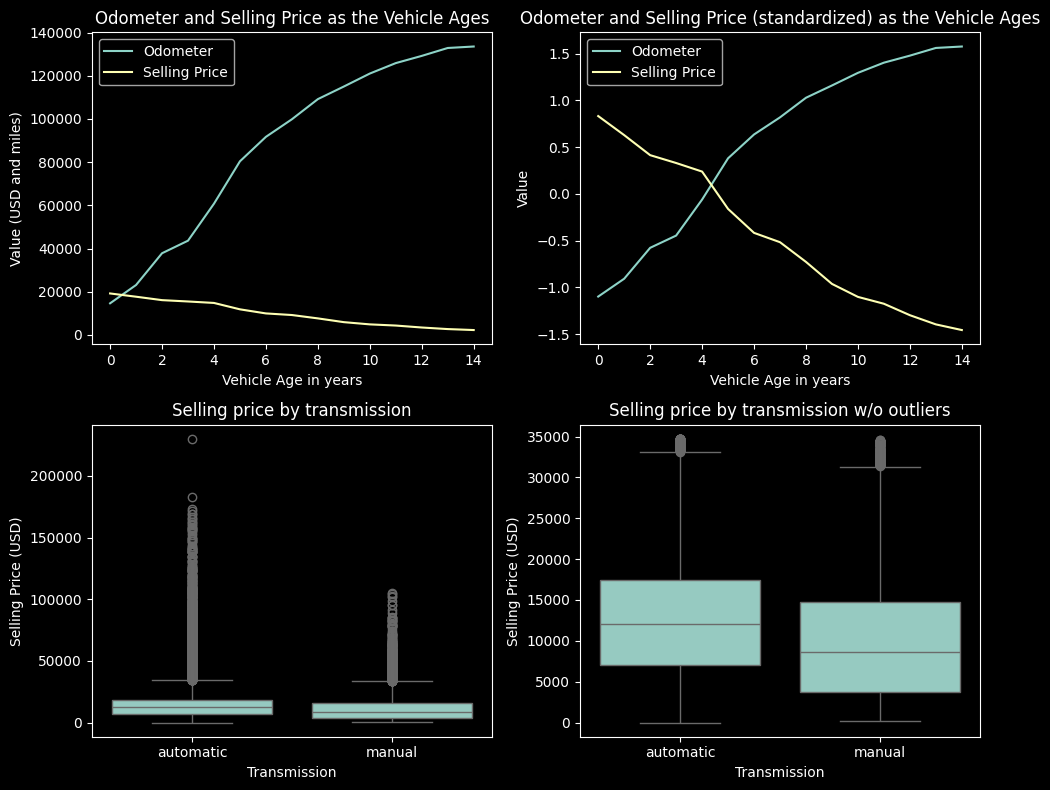

In [230]:
print("Correlation matrix:\n", cars_continuous_df[['odometer', 'vehicleage', 'sellingprice']].corr(method='pearson'))
transmission_corr = pd.get_dummies(cars_df[['sellingprice', 'transmission']], drop_first=True).corr(method='pearson')
print("Correlation between selling price and transmission type:\n", transmission_corr.loc['sellingprice', 'transmission_manual'])

scaler = StandardScaler()

std_cars_no_outliers_df = cars_no_outliers_df.copy()
std_cars_no_outliers_df[['sellingprice', 'odometer']] = scaler.fit_transform(cars_no_outliers_df[['sellingprice', 'odometer']])

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.lineplot(data=cars_no_outliers_df, x='vehicleage', y='odometer', label='Odometer', errorbar=None, ax=axes[0, 0])
sns.lineplot(data=cars_no_outliers_df, x='vehicleage', y='sellingprice', label='Selling Price', errorbar=None, ax=axes[0, 0])
axes[0, 0].set_xlabel('Vehicle Age in years')
axes[0, 0].set_ylabel('Value (USD and miles)')
axes[0, 0].set_title('Odometer and Selling Price as the Vehicle Ages')
axes[0, 0].legend()

sns.lineplot(data=std_cars_no_outliers_df, x='vehicleage', y='odometer', label='Odometer', errorbar=None, ax=axes[0, 1])
sns.lineplot(data=std_cars_no_outliers_df, x='vehicleage', y='sellingprice', label='Selling Price', errorbar=None, ax=axes[0, 1])
axes[0, 1].set_xlabel('Vehicle Age in years')
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_title('Odometer and Selling Price (standardized) as the Vehicle Ages')
axes[0, 1].legend()

transmission_sellingprice = pd.concat([cars_continuous_df['sellingprice'], cars_categorical_df['transmission']], axis=1)
sns.boxplot(data=transmission_sellingprice, x='transmission', y='sellingprice', ax=axes[1, 0])
axes[1, 0].set_xlabel('Transmission')
axes[1, 0].set_ylabel('Selling Price (USD)')
axes[1, 0].set_title('Selling price by transmission')

transmission_sellingprice['sellingprice'] = remove_outliers(transmission_sellingprice[['sellingprice']])
sns.boxplot(data=transmission_sellingprice, x='transmission', y='sellingprice', ax=axes[1, 1])
axes[1, 1].set_xlabel('Transmission')
axes[1, 1].set_ylabel('Selling Price (USD)')
axes[1, 1].set_title('Selling price by transmission w/o outliers')

plt.tight_layout()
plt.show()

### 2. What is the prediction of the selling price of a vehicle based on its various features?

In this section, we aim to predict the selling price of a vehicle using various features such as year, condition, odometer, mmr, salemonth, vehicleage, and transmission type. We utilize different regression models including Decision Tree Regressor, Random Forest Regressor, and MLP Regressor to achieve this.

- **Decision Tree Regressor**: Hyperparameters such as `max_depth`, `max_features`, and `min_samples_split` are tuned using `RandomizedSearchCV`.
- **Random Forest Regressor**: Similar hyperparameters are tuned along with `n_estimators`.
- **MLP Regressor**: Hyperparameters such as `hidden_layer_sizes`, `learning_rate_init`, `alpha`, and `max_iter` are tuned.
---
- The best model for each regressor is selected based on the tuning results.
- Predictions are made on the test set.
- The performance of the models is evaluated using metrics such as RMSE, MAE.
- Actual vs Predicted Selling Prices and Residual Histograms are plotted to visualize the performance.

The results from these models provide insights into the effectiveness of different regression techniques in predicting vehicle selling prices based on the given features.

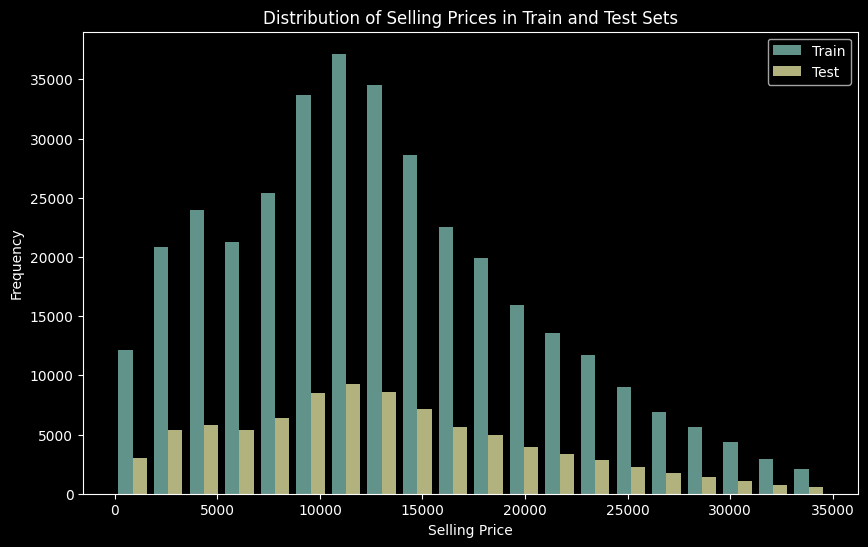

In [231]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

features = continuous_features + ['transmission']
cont_feat_no_price = continuous_features.copy()
cont_feat_no_price.remove('sellingprice')
car_feat_no_outliers_df = cars_df[cars_df.index.isin(cars_no_outliers_df.index)].copy()
car_feat_no_outliers_df[cont_feat_no_price] = scaler.fit_transform(car_feat_no_outliers_df[cont_feat_no_price])
X = car_feat_no_outliers_df[features]
X = pd.get_dummies(X, columns=['transmission'], drop_first=True)
y = car_feat_no_outliers_df['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure(figsize=(10, 6))
plt.hist([y_train, y_test], bins=20, label=['Train', 'Test'], alpha=0.7)
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.title('Distribution of Selling Prices in Train and Test Sets')
plt.legend()
plt.show()

In [232]:
from sklearn.model_selection import RandomizedSearchCV

def find_best_hyperparams(param_dist, model, fit_train_features, fit_train_target, regression = True):
    scoring = []
    refit = ''
    if regression:
        scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error']
        refit = 'neg_mean_absolute_error'
    else:
        scoring = ['accuracy']
        refit = 'accuracy'

    grid_search = RandomizedSearchCV(model, param_dist, n_iter=5, cv=5, scoring=scoring, refit=refit, n_jobs=-1)

    grid_search.fit(fit_train_features, fit_train_target)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    results = pd.DataFrame(grid_search.cv_results_)

    print("All Parameters and their Scores:")
    print(results)
    print(f'Best Parameters: {best_params}')
    print(f'Best Score: {best_score}')
    return best_params, results

def predict_and_plot(regressor, best_params, X_train, X_test, y_train, y_test):
    best_model = regressor(**best_params, random_state=0)
    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted Selling Prices')

    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.hist(residuals, bins=50, range=(-3000, 3000))
    plt.axvline(x=0, color='k', linestyle='--', lw=2)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Residual Histogram')

    plt.tight_layout()
    plt.show()


All Parameters and their Scores:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.066518      0.036611         0.039803        0.011867   
1       0.330978      0.055109         0.018646        0.006686   
2       0.242300      0.038331         0.012214        0.001130   
3       0.252226      0.009237         0.012140        0.000805   
4       0.713651      0.011890         0.027528        0.001902   

  param_max_depth param_max_features  param_min_samples_split  \
0            None                  3                       18   
1               3                  3                       19   
2               7                  1                        9   
3               7               sqrt                        3   
4            None                  3                       18   

                                              params  \
0  {'max_depth': None, 'max_features': 3, 'min_sa...   
1  {'max_depth': 3, 'max_features': 3, 'min_sampl...   
2  {'

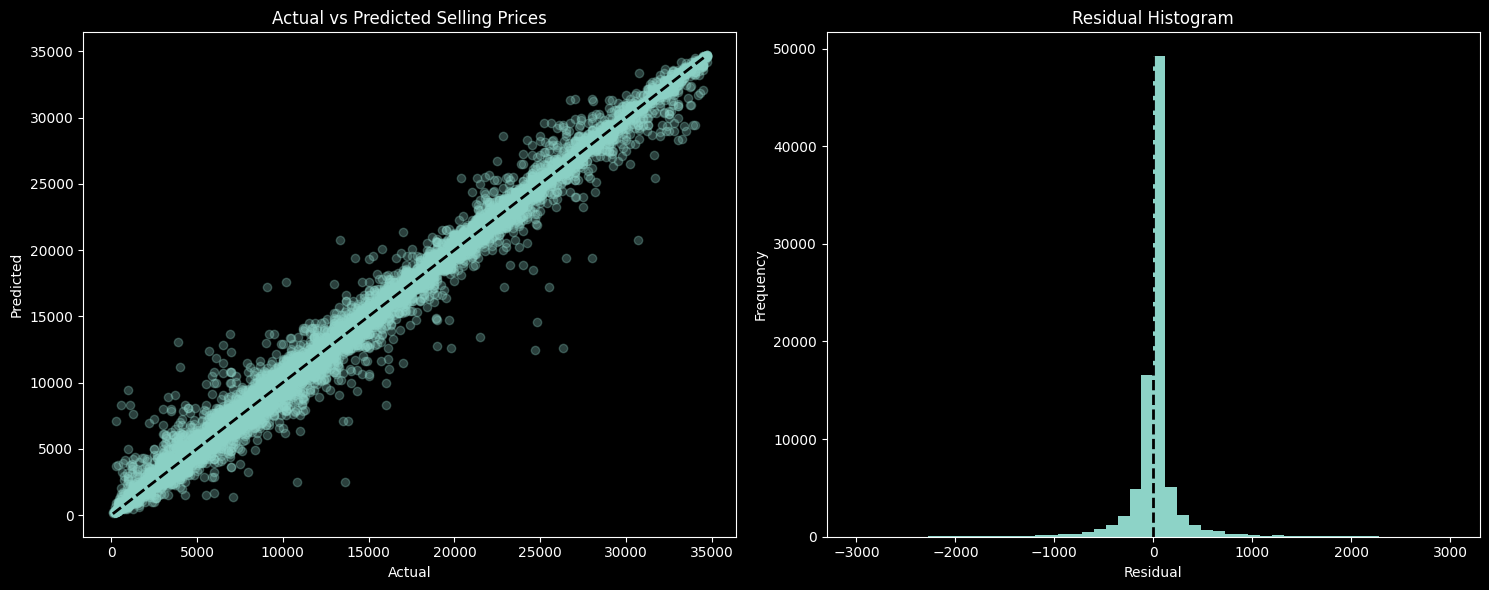

In [225]:
from scipy.stats import randint, uniform

param_dist = {
   'max_depth': [None] + list(range(3, 12)),
   'max_features': ['sqrt'] + list(range(1, len(X.columns) // 2)),
   'min_samples_split': randint(2, 20)
}

best_params, param_scores = find_best_hyperparams(param_dist, DecisionTreeRegressor(random_state=0), X_train, y_train)

predict_and_plot(DecisionTreeRegressor, best_params, X_train, X_test, y_train, y_test)

All Parameters and their Scores:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       3.547467      0.966943         0.085569        0.052059   
1      16.413415      0.201532         0.059640        0.005380   
2       7.513896      0.090418         0.042932        0.002009   
3       9.591280      1.138523         0.044917        0.003896   
4       5.907533      2.064582         0.038516        0.004705   

   param_max_depth  param_max_features  param_min_samples_split  \
0                5                   1                        7   
1                6                   3                        9   
2                7                   1                       10   
3                6                   2                       10   
4                7                   3                        6   

   param_n_estimators                                             params  \
0                  14  {'max_depth': 5, 'max_features': 1, 'min_sampl...   
1        

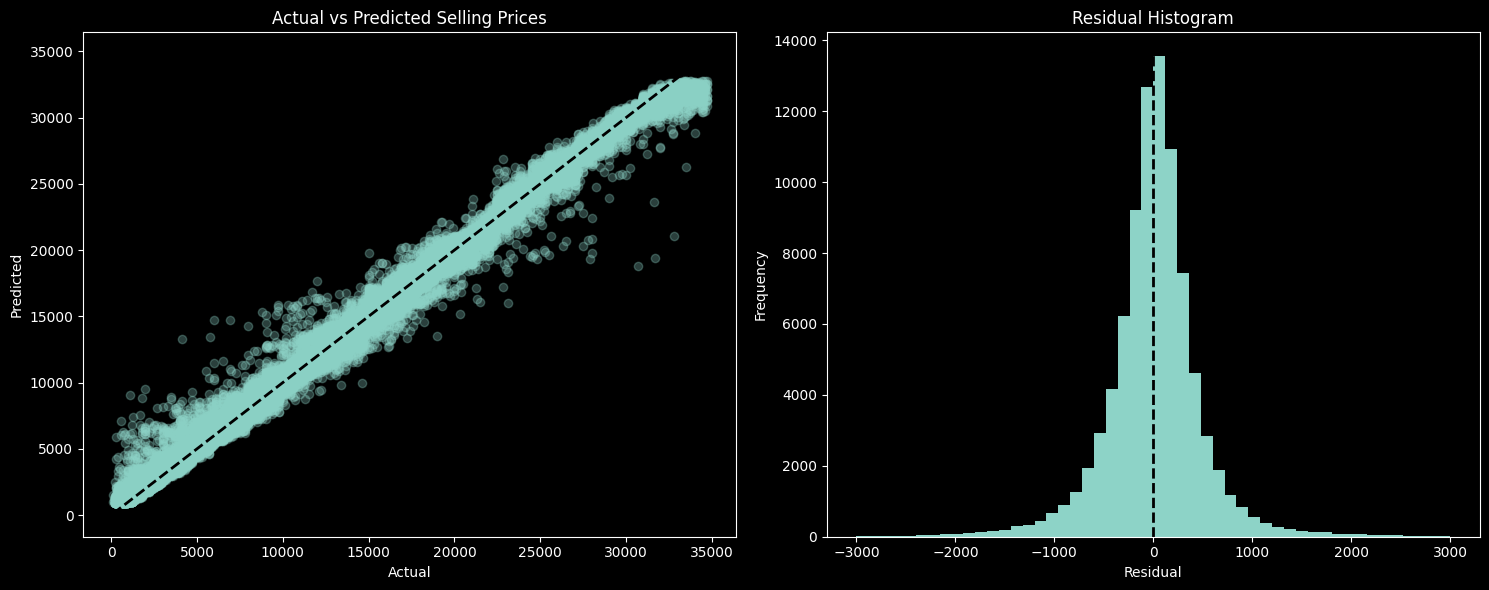

In [233]:
from sklearn.ensemble import RandomForestRegressor

param_dist = {
    'max_depth': randint(5, 10),
    'max_features': ['sqrt'] + list(range(1, len(X.columns) // 2)),
    'min_samples_split': randint(5, 20),
    'n_estimators': randint(10, 30)
}

best_params, param_scores = find_best_hyperparams(param_dist, RandomForestRegressor(random_state=0, n_jobs=-1), X_train, y_train)

best_params['n_jobs']=-1
predict_and_plot(RandomForestRegressor, best_params, X_train, X_test, y_train, y_test)

/Users/p997bjd/uniproj/ml/mini1/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/p997bjd/uniproj/ml/mini1/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(


All Parameters and their Scores:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_alpha  \
0      21.684683      0.625360         0.098696        0.016451     0.097248   
1      21.781206      4.542128         0.052298        0.009334     0.015303   
2      20.304223      0.992977         0.066162        0.012816     0.026085   
3      19.320413      2.144053         0.041078        0.006125     0.067949   
4      19.864535      4.449478         0.060536        0.016671     0.045584   

  param_hidden_layer_sizes  param_learning_rate_init  param_max_iter  \
0                 (20, 10)                  0.017789              20   
1                  (10, 5)                  0.042885              28   
2                 (20, 10)                  0.034884              29   
3                  (10, 5)                  0.068664              20   
4                 (20, 10)                  0.077453              26   

                                              params 

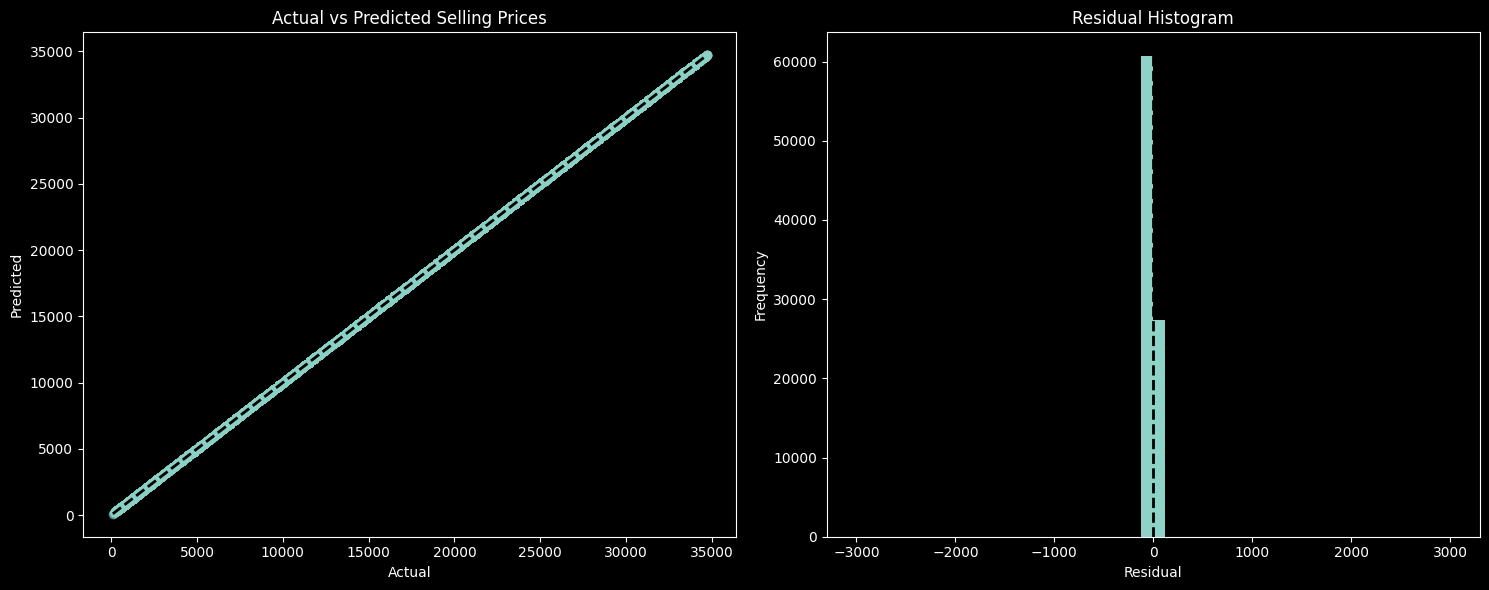

In [234]:
from sklearn.neural_network import MLPRegressor

param_dist = {
    'hidden_layer_sizes': [(10, 5), (20, 10)],
    'learning_rate_init': uniform(0.01, 0.1),
    'alpha': uniform(0.01, 0.1),
    'max_iter': randint(20, 30)
}

best_params, param_scores = find_best_hyperparams(param_dist, MLPRegressor(learning_rate='constant', activation='relu', solver='adam'), X_train, y_train)

best_model = MLPRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Selling Prices')

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.hist(residuals, bins=50, range=(-3000, 3000))
plt.axvline(x=0, color='k', linestyle='--', lw=2)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

plt.tight_layout()
plt.show()


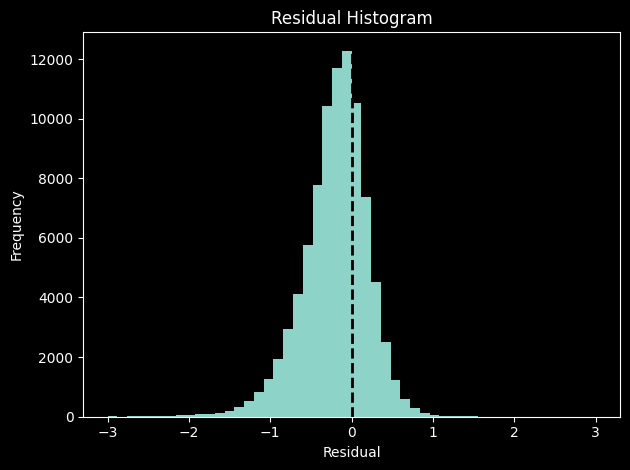

In [239]:
plt.hist(residuals, bins=50, range=(-3, 3))
plt.axvline(x=0, color='k', linestyle='--', lw=2)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

plt.tight_layout()
plt.show()

### 3. What is the classification of the vehicle's condition based on its age, mileage, and other features?"

In this section, we aim to classify the vehicle's condition label (`'bad'`, `'average'`, `'good'`, `'very good'`) based on its age, mileage, and recommended price (mmr). The following steps were taken to solve this classification problem:

- The dataset was split into training and testing sets using an 80-20 split after being standardized.
- For each classifier, hyperparameters were tuned using `RandomizedSearchCV` to find the best parameters, much like in the previous section.
- The hyperparameters tuned for each classifier were:
    - **DecisionTreeClassifier**: `max_depth`, `max_features`, `min_samples_split`
    - **RandomForestClassifier**: `max_depth`, `max_features`, `min_samples_split`, `n_estimators`
    - **MLPClassifier**: `hidden_layer_sizes`, `learning_rate_init`, `alpha`, `max_iter`
---
- The performance of the models was evaluated using the accuracy coeficient confusion matrices and ROC curves.
- The confusion matrix was plotted to visualize the classification results.
- ROC curves were plotted for each condition label to evaluate the model's performance.

These steps provided insights into the effectiveness of different classification techniques in predicting vehicle condition labels based on the given features.

In [210]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

cols = ['vehicleage', 'odometer', 'mmr']

cars_no_outliers_df[cols] = scaler.fit_transform(car_feat_no_outliers_df[cols])

X_classification = cars_no_outliers_df[['vehicleage', 'odometer', 'mmr']]
y_classification = cars_df.loc[cars_no_outliers_df.index, 'conditionlabel']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=0)

def classify_and_plot(model, best_params, X_train_class, X_test_class, y_train_class, y_test_class):
    best_model = model(**best_params, random_state=0)
    best_model.fit(X_train_class, y_train_class)

    dtree_classifier = model(random_state=42)
    dtree_classifier.fit(X_train_class, y_train_class)
    y_pred_class = dtree_classifier.predict(X_test_class)
    y_pred_proba = dtree_classifier.predict_proba(X_test_class)

    label_order = ['bad', 'average', 'good', 'very good']

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test_class, y_pred_class, labels=label_order)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.gca().invert_yaxis()
    plt.title('Confusion Matrix for Condition Label Classification')

    plt.subplot(1, 2, 2)
    for i, label in enumerate(label_order):
        fpr, tpr, _ = roc_curve(y_test_class == label, y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(y_test_class == label, y_pred_proba[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Condition Label Classification')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

/var/folders/_3/g9t2yqjj403drcv7xdxch0v00000gn/T/ipykernel_30472/1088378149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_no_outliers_df[cols] = scaler.fit_transform(car_feat_no_outliers_df[cols])


All Parameters and their Scores:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.412072      0.155119         0.188359        0.007950   
1       2.154011      0.044499         0.185658        0.016068   
2       2.122272      0.045986         0.191570        0.023699   
3       2.047001      0.106808         0.126922        0.022389   
4       2.476621      0.098209         0.154676        0.016488   

   param_max_depth param_max_features  param_min_samples_split  \
0               22               sqrt                        8   
1               20                  2                        5   
2               12                  6                        5   
3               12                  7                        8   
4               25                  5                        8   

                                              params  split0_test_accuracy  \
0  {'max_depth': 22, 'max_features': 'sqrt', 'min...              0.374663   
1  {'max_de

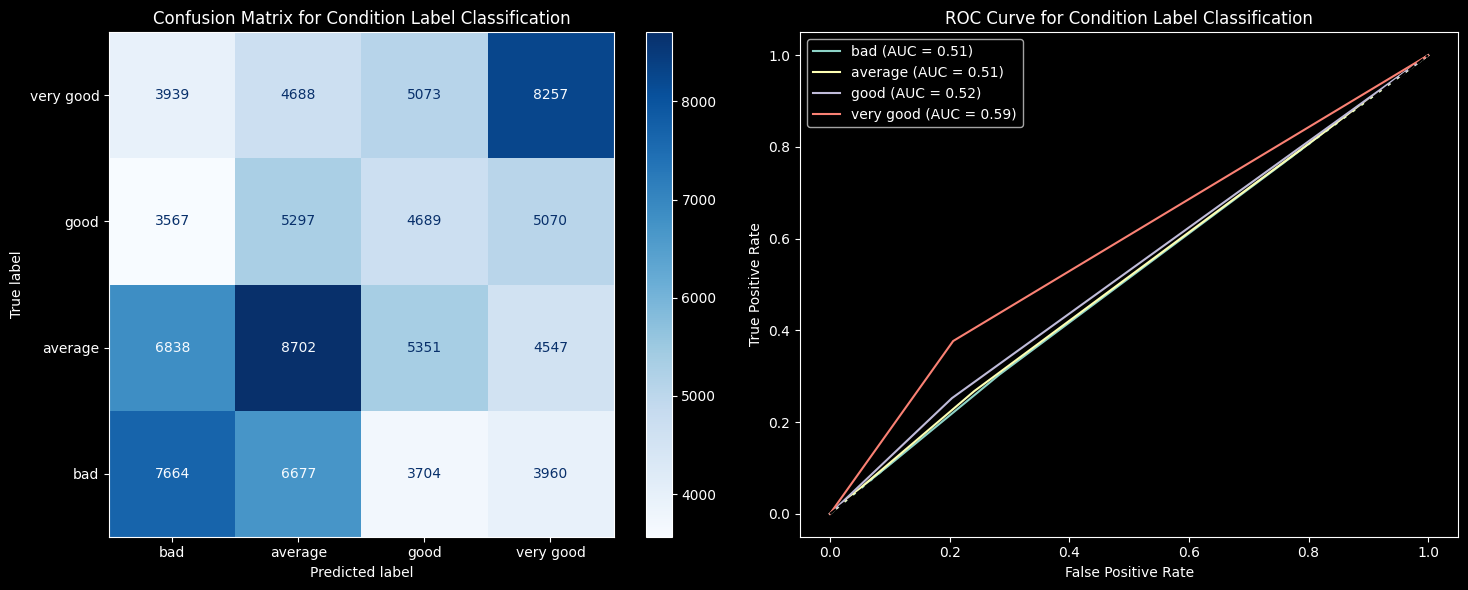

In [211]:
from sklearn.tree import DecisionTreeClassifier

param_dist = {
   'max_depth': [None] + list(range(5, 30)),
   'max_features': ['sqrt'] + list(range(1, len(X.columns))),
   'min_samples_split': randint(2, 10)
}

best_params, param_scores = find_best_hyperparams(param_dist, DecisionTreeClassifier(random_state=0), X_train_class, y_train_class, regression=False)

classify_and_plot(DecisionTreeClassifier, best_params, X_train_class, X_test_class, y_train_class, y_test_class)

All Parameters and their Scores:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      22.031174      1.538587         2.315478        0.286173   
1      53.473346      0.312582         1.746077        0.243212   
2      37.336730      6.573268         1.030062        0.340465   
3      15.447397      6.054573         0.362981        0.178389   
4      21.060328      1.897701         0.286404        0.046515   

   param_max_depth param_max_features  param_min_samples_split  \
0               29               sqrt                        7   
1               26                  5                        7   
2               23                  4                        2   
3                9                  3                        7   
4               16                  6                        7   

   param_n_estimators                                             params  \
0                  22  {'max_depth': 29, 'max_features': 'sqrt', 'min...   
1              

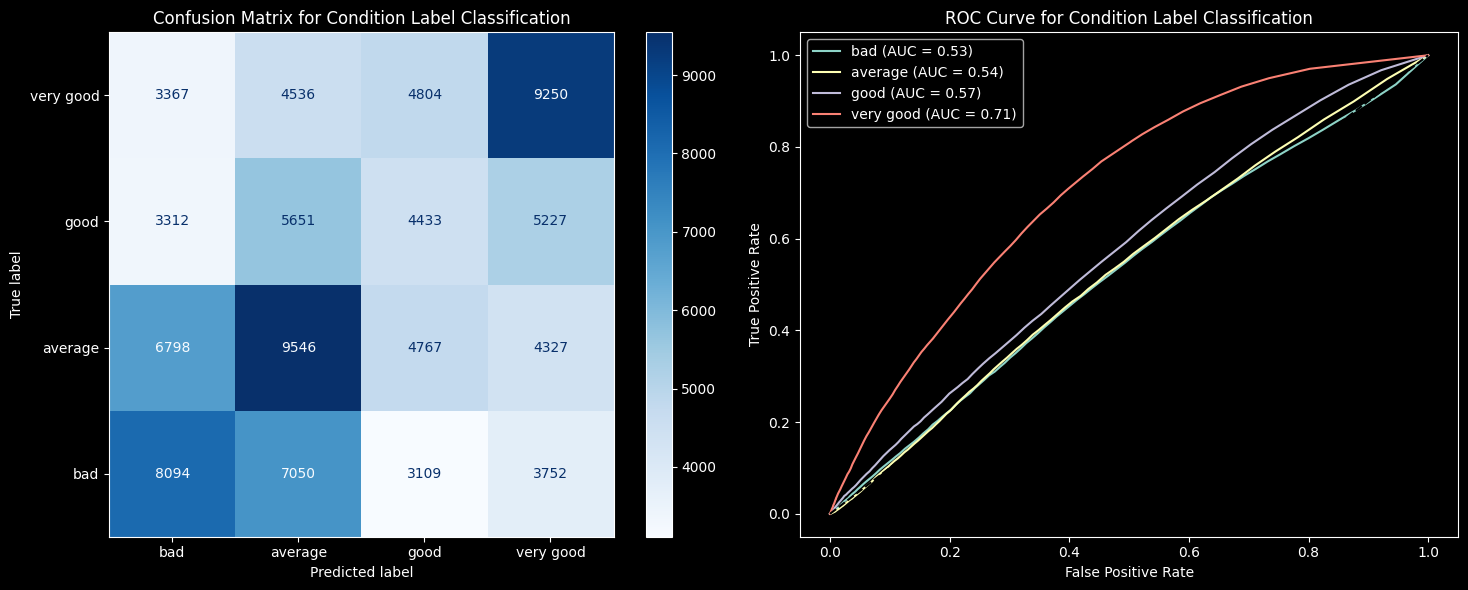

In [212]:
from sklearn.ensemble import RandomForestClassifier

param_dist = {
    'max_depth': [None] + list(range(5, 30)),
    'max_features': ['sqrt'] + list(range(1, len(X.columns))),
    'min_samples_split': randint(2, 10),
    'n_estimators': randint(10, 30)
}

best_params, param_scores = find_best_hyperparams(param_dist, RandomForestClassifier(random_state=0, n_jobs=-1), X_train_class, y_train_class, regression=False)

param_dist['n_jobs'] = -1
classify_and_plot(RandomForestClassifier, best_params, X_train_class, X_test_class, y_train_class, y_test_class)

/Users/p997bjd/uniproj/ml/mini1/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(


All Parameters and their Scores:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_alpha  \
0      26.193689      2.352377         0.199238        0.023213     0.108471   
1      26.755799      3.893405         0.188774        0.013948     0.027255   
2      33.109870      9.999684         0.184704        0.020825     0.058095   
3      26.116049      2.209854         0.128612        0.022175     0.018171   
4      17.554461      3.449009         0.116138        0.034125     0.027087   

  param_hidden_layer_sizes  param_learning_rate_init  param_max_iter  \
0                 (20, 10)                  0.937425              32   
1                 (20, 10)                  1.062694              31   
2                 (20, 10)                  0.432346              31   
3                 (20, 10)                  0.370528              35   
4                  (10, 5)                  0.636765              35   

                                              params 

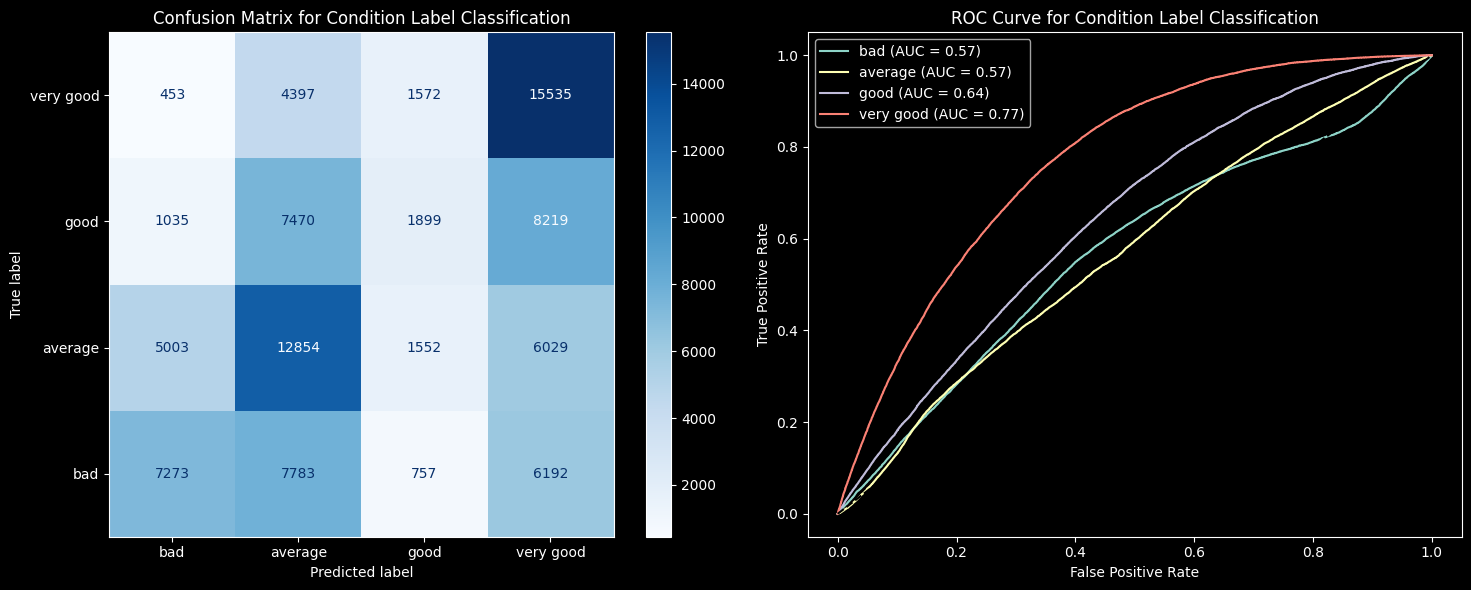

In [214]:
from sklearn.neural_network import MLPClassifier

param_dist = {
    'hidden_layer_sizes': [(10, 5), (20, 10)],
    'learning_rate_init': uniform(0.1, 1),
    'alpha': uniform(0.01, 0.1),
    'max_iter': randint(30, 40)
}

best_params, param_scores = find_best_hyperparams(param_dist, MLPClassifier(random_state=0), X_train_class, y_train_class, regression=False)

classify_and_plot(MLPClassifier, best_params, X_train_class, X_test_class, y_train_class, y_test_class)